# **Anomaly Detection in Image Streams with Machine Learning**

## Import Required Libraries

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import math
import time
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import io
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from matplotlib import pyplot as plt
from skimage.feature import graycomatrix, graycoprops
import io
from math import sqrt
from google.colab.patches import cv2_imshow
from pmdarima.arima import auto_arima
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
start_time = time.time()

## Upload the Dataset from a local directory.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The image data is read and stored in a list named dataset.

In [ ]:
dataset = []
dataset_image_list = []

filenames = glob.glob("/content/drive/MyDrive/UOM/FYP/datasets/June2023/Volcano/Small_Dataset/Unlabeled/"+"*.jpg")
filenames.sort()
for img in filenames:
  n = cv2.imread(img, 0)
  if n is not None:
    dataset.append(n)
    dataset_image_list.append(img)
print("The length of the image dataset: ", len(dataset))

The length of the image dataset:  100


**Defining required data and variables**



*   No. Of Normal images = 80
*   No. Of Anomaly images = 20
*   Training set size = 70
*   Test set size = 30








In [ ]:
anomaly_image = int(input("The image (number) at which anomaly occurs in the dataset: "))
split_percentage = int(input("Percentage at which the dataset should be split: "))
dataset_length = len(dataset)

The image (number) at which anomaly occurs in the dataset: 80
Percentage at which the dataset should be split: 70


## Preprocessing of the data

In [ ]:
crop_y = 25
crop_x = dataset[0].shape[1]

In [ ]:
def crop_image(img):
  cropped_image = img[crop_y:dataset[0].shape[0], 0:crop_x]
  return cropped_image

**Example of a cropped image,**

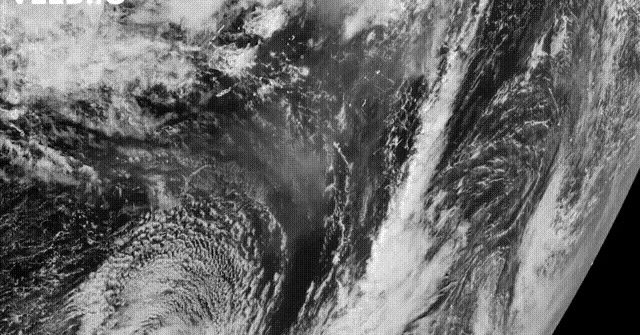

-1

In [ ]:
cropped_img = crop_image(dataset[0])
cv2_imshow(cropped_img)
cv2.waitKey(0)

In [ ]:
def normalize(image):
  normalizedImg = cv2.normalize(image, None,
                                alpha = 0, beta = 255,
                                norm_type = cv2.NORM_MINMAX)
  return normalizedImg

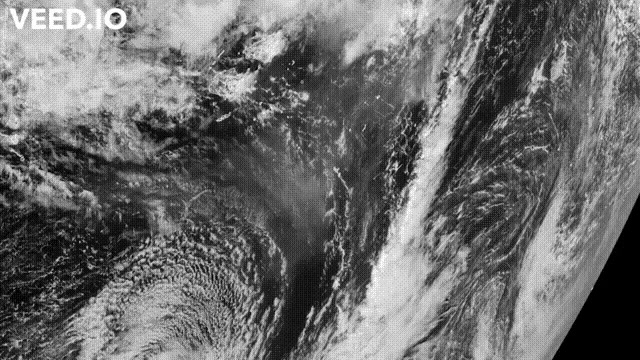

-1

In [ ]:
normalizedImage = normalize(dataset[0])
cv2_imshow(normalizedImage)
cv2.waitKey(0)

**Noise removal** is done by using the Gaussian Filter

The 2D isotropic Gaussian kernel,

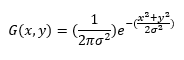

    where, G(x,y) = Gaussian distribution
	  σ = standard deviation


In [ ]:
def gaussianBlur(image):
    gaussian = cv2.GaussianBlur(image,(5,5),0)
    return gaussian

## Feature Extraction

Function to calculate the histogram of a given image.

This will be needed for the calculation of the first-order statistical features.

In [ ]:
def calcHistogram(image):
    hist, edges, patches = plt.hist(image.ravel(), 256, [0, 256])
    return hist

Function to find the average of the calculated values for each pixel/pixel neighbourhoods of an image.

In [ ]:
def findAverage(list):
    avg = sum(list)/len(list)
    return avg

In [ ]:
#Extracting features
G = 256 #NUmber of gray levels in an image

### First-Order Statistical Features

Function to calculate the probability density value that will be needed for the first-order feature calculation.

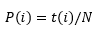

    where, P(i) = probability density of the intensity level, i
	  t(i) = the total number of pixels that has the intensity level, i
	  N = the total number of pixels in the image


In [ ]:
def calc_Probability_Density(hist_i_value, size):
    return (hist_i_value/size)

Statistical Mean calculation

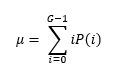

In [ ]:
def Stat_Mean(i, prob_density):
    mean = (i * (prob_density))
    return mean

Average COntrast calculation

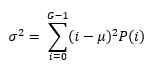

In [ ]:
def Stat_Avg_Contrast(i, prob_density, mean):
    avg_contrast = pow((i-mean),2) * prob_density
    return avg_contrast

Skewness of a pixel calculation

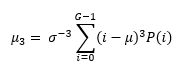

In [ ]:
def Stat_Skewness(i, mean, prob_density):
    skewness_component = pow((i-mean),3) * prob_density
    return skewness_component

Kurtosis of a pixel calculation

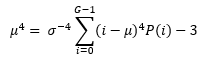

In [ ]:
def Stat_Kurtosis(i, mean, prob_density):
    kurtosis_component = (pow((i-mean),4) * prob_density) - 3
    return kurtosis_component

Energy of a pixel calculation

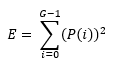

In [ ]:
def Stat_Energy(prob_density):
    energy = pow(prob_density,2)
    return energy

In [ ]:
def Stat_Features_Set1(i, mean, prob_density):
    avg_contrast = pow((i - mean), 2) * prob_density
    skewness_component = pow((i - mean), 3) * prob_density
    kurtosis_component = (pow((i - mean), 4) * prob_density) - 3
    energy = pow(prob_density, 2)
    return avg_contrast, skewness_component, kurtosis_component, energy

In [ ]:
def calc_Stat_Features(img):
    Return_Set = []
    stat_mean=0
    stat_avg_contrast=0
    skewness_component=0
    kurtosis_component=0
    stat_energy=0
    hist = calcHistogram(img)
    size = img.size

    for i in range(G):
        p_d = calc_Probability_Density(hist[i], size)
        stat_mean += Stat_Mean(i, p_d)

    for i in range(G):
        p_d = calc_Probability_Density(hist[i], size)
        p1, p2, p3, p4 = Stat_Features_Set1(i, stat_mean, p_d)
        stat_avg_contrast += p1  # variance^2 (avg_contrast)
        skewness_component += p2 #skewness_component
        kurtosis_component += p3 #kurtosis_component

    skewness = pow(stat_avg_contrast,(-3/2)) * skewness_component
    kurtosis = pow(stat_avg_contrast,(-4/2)) * kurtosis_component
    return stat_mean, stat_avg_contrast, skewness, kurtosis

### Gabor Wavelet Feature Extraction

The Gabor function used,

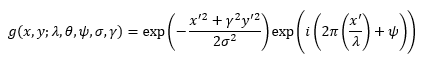

    where, x^'=xcos⁡θ + ysin⁡θ
	  y^'=-xsin⁡θ + ycos⁡θ
	  λ=wavelength of the sine component
	  θ=orientation of the parallel lines formed by the kernel
	  ψ=phase offset
	  σ=standard deviation of the gaussian envelope
	  ϒ=aspect ratio


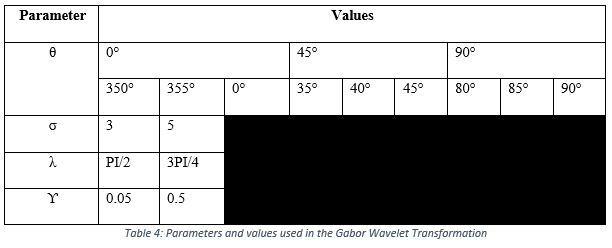

In [ ]:
def gaborFilter(img):
    num = 1
    fimg_list = []
    for theta in range(3):  # 0, 45, 90
        theta = theta / 4 * np.pi  # theta 0, 1/4, 1/2 => 0, 45, 90
        for theta_i in (theta - 10, theta - 5, theta):
            for sigma in (3, 5):
                for lamda in np.arange(np.pi / 2, np.pi, np.pi / 4):
                    for gamma in (0.05, 0.5):
                        gabor_label = 'Gabor' + str(num)
                        kernel = cv2.getGaborKernel((5, 5), sigma, theta_i, lamda, gamma, 0,
                                                    ktype=cv2.CV_32F)
                        fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                        filtered_img = fimg.reshape(-1)

                        fimg_list.append(fimg)

                        num += 1
    return fimg_list

    # ktype is the data type. so it's saying that after the kernel is generated, store it as 32 float


### Edge Detected Features

In [ ]:
def cannyEdge(img):
    edges = cv2.Canny(img, 100, 200)
    edges2 = edges.reshape(-1)
    return edges2

In [ ]:
def edge_roberts(img):
    edge_robert = roberts(img)
    edge_robert2 = edge_robert.reshape(-1)
    return edge_robert2

In [ ]:
def edge_sobel(img):
    edge_sobel1 = sobel(img)
    edge_sobel2 = edge_sobel1.reshape(-1)
    return edge_sobel2

In [ ]:
def edge_scharr(img):
    edge_scharr1 = scharr(img)
    edge_scharr2 = edge_scharr1.reshape(-1)
    return edge_scharr2

In [ ]:
def edge_prewitt(img):
    edge_prewitt1 = prewitt(img)
    edge_prewitt2 = edge_prewitt1.reshape(-1)
    return edge_prewitt2

### Other extracted features: Gaussian S3 and S7, Entropy features

In [ ]:
def gaussianFeature(img):
    gaussian_img = nd.gaussian_filter(img, sigma = 3) #Gaussian S3
    gaussian_img1 = gaussian_img.reshape(-1)
    gaussian_img2 = nd.gaussian_filter(img, sigma=7) #Gaussian S7
    gaussian_img3 = gaussian_img2.reshape(-1)
    return gaussian_img1, gaussian_img3

In [ ]:
def entropyFeature(img):
    entropy_img = entropy(img, disk(1))
    entropy_img1 = entropy_img.reshape(-1)
    return entropy_img1

### GLCM Feature Extraction

In [ ]:
def glcmFeatures(img):
    glcm = graycomatrix(img, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    diss_sim = graycoprops(glcm, 'dissimilarity')[0, 0]
    corr = graycoprops(glcm, 'correlation')[0, 0]
    homogen = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    return diss_sim, corr, homogen, energy, contrast

### Preparing for Feature extraction

Defining the lists needed to store the calculated features for each image.

In [ ]:
contrast_stretched_image_list = []
num_CS = 0
Canny_Edges_list = []
Edge_Roberts_List = []
Edge_Sobel_List = []
Edge_Scharr_List = []
Edge_Prewitt_List = []
Gaussian_img1_List = []
Gaussian_img3_List = []
Variance_list = []
Stat_Mean_List = []
Stat_Avg_Contrast_List = []
Stat_Skewness_List = []
Stat_Kurtosis_List = []
Stat_Energy_List = []
Stat_Entropy_List = []
Gabor_Individual_List = []
GLCM_diss_sim_List = []
GLCM_corr_List = []
GLCM_homogen_List = []
GLCM_energy_List = []
GLCM_contrast_List = []

In [ ]:
df_extractedFeatures = pd.DataFrame()

### Feature Extraction

In [ ]:
prep_and_extract_start_time = time.time()

Extracting features for each image from the dataset.

length of images list,  100
0
length of images list,  100
1
length of images list,  100
2
length of images list,  100
3
length of images list,  100
4
length of images list,  100
5
length of images list,  100
6
length of images list,  100
7
length of images list,  100
8
length of images list,  100
9
length of images list,  100
10
length of images list,  100
11
length of images list,  100
12
length of images list,  100
13
length of images list,  100
14
length of images list,  100
15
length of images list,  100
16
length of images list,  100
17
length of images list,  100
18
length of images list,  100
19
length of images list,  100
20
length of images list,  100
21
length of images list,  100
22
length of images list,  100
23
length of images list,  100
24
length of images list,  100
25
length of images list,  100
26
length of images list,  100
27
length of images list,  100
28
length of images list,  100
29
length of images list,  100
30
length of images list,  100
31
length of images l

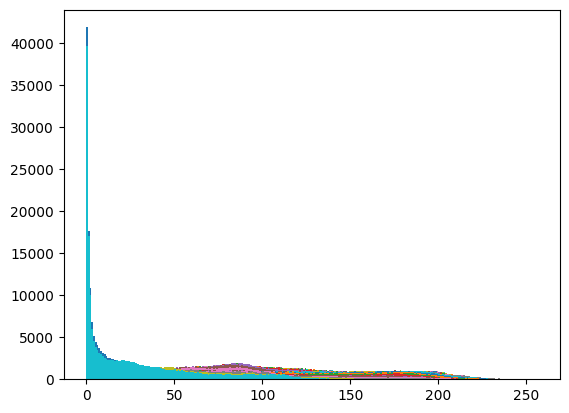

In [ ]:
for img in dataset:
  print("length of images list, ", len(dataset))
  cropped_img = crop_image(img)
  CS_img = normalize(cropped_img)
  contrast_stretched_image_list.append(CS_img)
  gaussian_img = gaussianBlur(CS_img)

  canny_edges2 = cannyEdge(gaussian_img)
  avg_canny_edges2 = findAverage(canny_edges2)
  Canny_Edges_list.append(avg_canny_edges2)

  edge_robert2 = edge_roberts(gaussian_img)
  avg_edge_roberts2 = findAverage(edge_robert2)
  Edge_Roberts_List.append(avg_edge_roberts2)

  edge_sobel2 = edge_sobel(gaussian_img)
  avg_edge_sobel2 = findAverage(edge_sobel2)
  Edge_Sobel_List.append(avg_edge_sobel2)

  edge_scharr2 = edge_scharr(gaussian_img)
  avg_edge_scharr2 = findAverage(edge_scharr2)
  Edge_Scharr_List.append(avg_edge_scharr2)

  edge_prewitt2 = edge_prewitt(gaussian_img)
  avg_edge_prewitt2 = findAverage(edge_prewitt2)
  Edge_Prewitt_List.append(avg_edge_prewitt2)

  gabor_images = gaborFilter(gaussian_img)
  total_gabor_image_values = [] #42 elements
  for img in gabor_images:
    g = img.reshape(-1)
    avg_g = findAverage(g)
    total_gabor_image_values.append(avg_g)

  Gabor_Individual_List.append(total_gabor_image_values)

  stat_mean, stat_avg_contrast, skewness, kurtosis = calc_Stat_Features(gaussian_img)
  Stat_Mean_List.append(stat_mean)
  Stat_Avg_Contrast_List .append(stat_avg_contrast)
  Stat_Skewness_List.append(skewness)
  Stat_Kurtosis_List.append(kurtosis)

  diss_sim, corr, homogen, energy, contrast = glcmFeatures(gaussian_img)
  GLCM_diss_sim_List.append(diss_sim)
  GLCM_corr_List.append(corr)
  GLCM_homogen_List.append(homogen)
  GLCM_energy_List.append(energy)
  GLCM_contrast_List.append(contrast)

  print(num_CS)
  num_CS = num_CS + 1


In [ ]:
Gabor_Total_Dict = {}
for i in range(len(Gabor_Individual_List[0])):
  Gabor_Total_Dict['GB'+str(i)]=[]

for i in Gabor_Individual_List:
  image_values = i
  num = 0
  for j in image_values:
    label = 'GB'+str(num)
    val = Gabor_Total_Dict[label]
    val.append(j)
    Gabor_Total_Dict[label] = val
    num += 1

print("Length of the Gabor dictionary", len(Gabor_Total_Dict))
Gray_Images_List = []
for i in range(len(dataset)):
  Gray_Images_List.append(i+1)

Length of the Gabor dictionary 72


In [ ]:
prep_and_extract_end_time = time.time()

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


### Putting the extracted feature data into a Pandas Dataframe.

In [ ]:
df_extractedFeatures['Gray Level Images'] = Gray_Images_List
df_extractedFeatures['CannyEdge'] = Canny_Edges_list
df_extractedFeatures['EdgeRoberts'] = Edge_Roberts_List
df_extractedFeatures['EdgeSobel'] = Edge_Sobel_List
df_extractedFeatures['EdgeScharr'] = Edge_Scharr_List
df_extractedFeatures['EdgePrewitt'] = Edge_Prewitt_List
df_extractedFeatures['StatMean'] = Stat_Mean_List
df_extractedFeatures['StatAvgContrast'] = Stat_Avg_Contrast_List
df_extractedFeatures['StatSkewness'] = Stat_Skewness_List
df_extractedFeatures['StatKurtosis'] = Stat_Kurtosis_List

Gabor_num = 0
for i in range(len(Gabor_Total_Dict)):
  label = 'GB' + str(Gabor_num)
  val = Gabor_Total_Dict[label]
  df_extractedFeatures[label] = val
  Gabor_num += 1

df_extractedFeatures['GLCM_Diss_similarity'] = GLCM_diss_sim_List
df_extractedFeatures['GLCM_Correlation'] = GLCM_corr_List
df_extractedFeatures['GLCM_Homogeneity'] = GLCM_homogen_List
df_extractedFeatures['GLCM_Energy'] = GLCM_energy_List
df_extractedFeatures['GLCM_Contrast'] = GLCM_contrast_List

print(df_extractedFeatures.head())

df_extractedFeatures.to_csv('drive/MyDrive/UOM/FYP/Features.csv')
print("end")

   Gray Level Images  CannyEdge  EdgeRoberts  EdgeSobel  EdgeScharr  \
0                  1  26.899883     0.035398    0.04609    0.046542   
1                  2  26.899883     0.035398    0.04609    0.046542   
2                  3  26.899883     0.035398    0.04609    0.046542   
3                  4  26.901073     0.035398    0.04609    0.046542   
4                  5  26.901073     0.035398    0.04609    0.046542   

   EdgePrewitt    StatMean  StatAvgContrast  StatSkewness  StatKurtosis  ...  \
0     0.045517  104.345961      2994.176608      0.223304       2.21035  ...   
1     0.045517  104.345961      2994.176608      0.223304       2.21035  ...   
2     0.045517  104.345961      2994.176608      0.223304       2.21035  ...   
3     0.045517  104.345905      2994.188512      0.223303       2.21034  ...   
4     0.045517  104.345905      2994.188512      0.223303       2.21034  ...   

         GB67      GB68      GB69        GB70        GB71  \
0  126.370117  0.000065  0.0000

### Plotting the Feature data

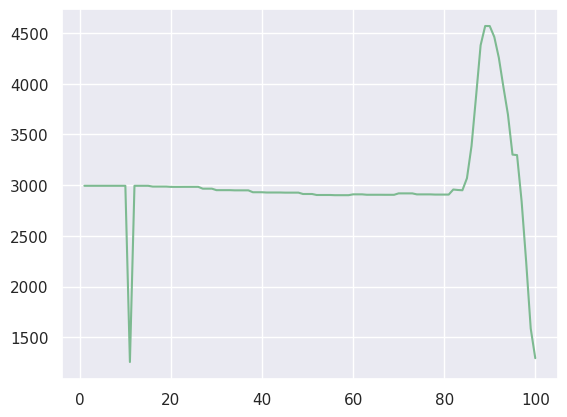

In [ ]:
sn.set()
sn.set_palette("crest")
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['StatAvgContrast'], label="StatAvgContrast")
plt.show()

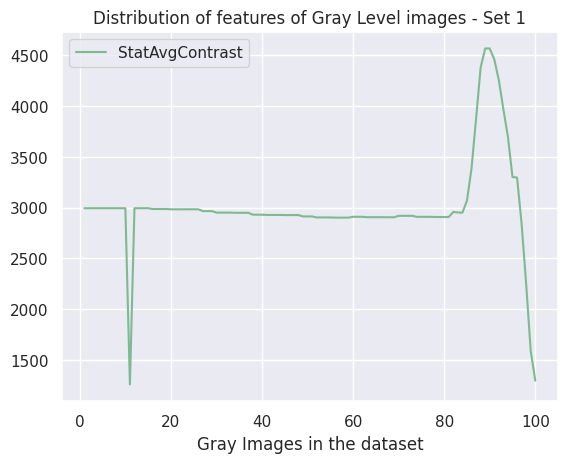

In [ ]:
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['StatAvgContrast'], label="StatAvgContrast")
plt.xlabel('Gray Images in the dataset')
plt.title('Distribution of features of Gray Level images - Set 1')
plt.legend()
plt.show()

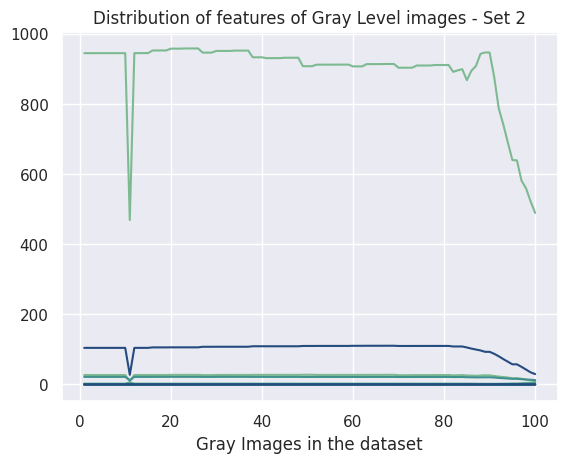

In [ ]:
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['CannyEdge'], label="CannyEdge")
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['EdgeRoberts'], label="EdgeRoberts")
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['EdgeSobel'], label="EdgeSobel")
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['EdgeScharr'], label="EdgeScharr")
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['EdgePrewitt'], label="EdgePrewitt")
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['StatMean'], label="StatMean")
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['StatSkewness'], label="StatSkewness")
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['StatKurtosis'], label="StatKurtosis")

plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['GLCM_Diss_similarity'], label="GLCM_Diss_similarity")
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['GLCM_Correlation'], label="GLCM_Correlation")
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['GLCM_Homogeneity'], label="GLCM_Homogeneity")
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['GLCM_Energy'], label="GLCM_Energy")
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['GLCM_Contrast'], label="GLCM_Contrast")
plt.xlabel('Gray Images in the dataset')
plt.title('Distribution of features of Gray Level images - Set 2')
# plt.legend()
plt.show()


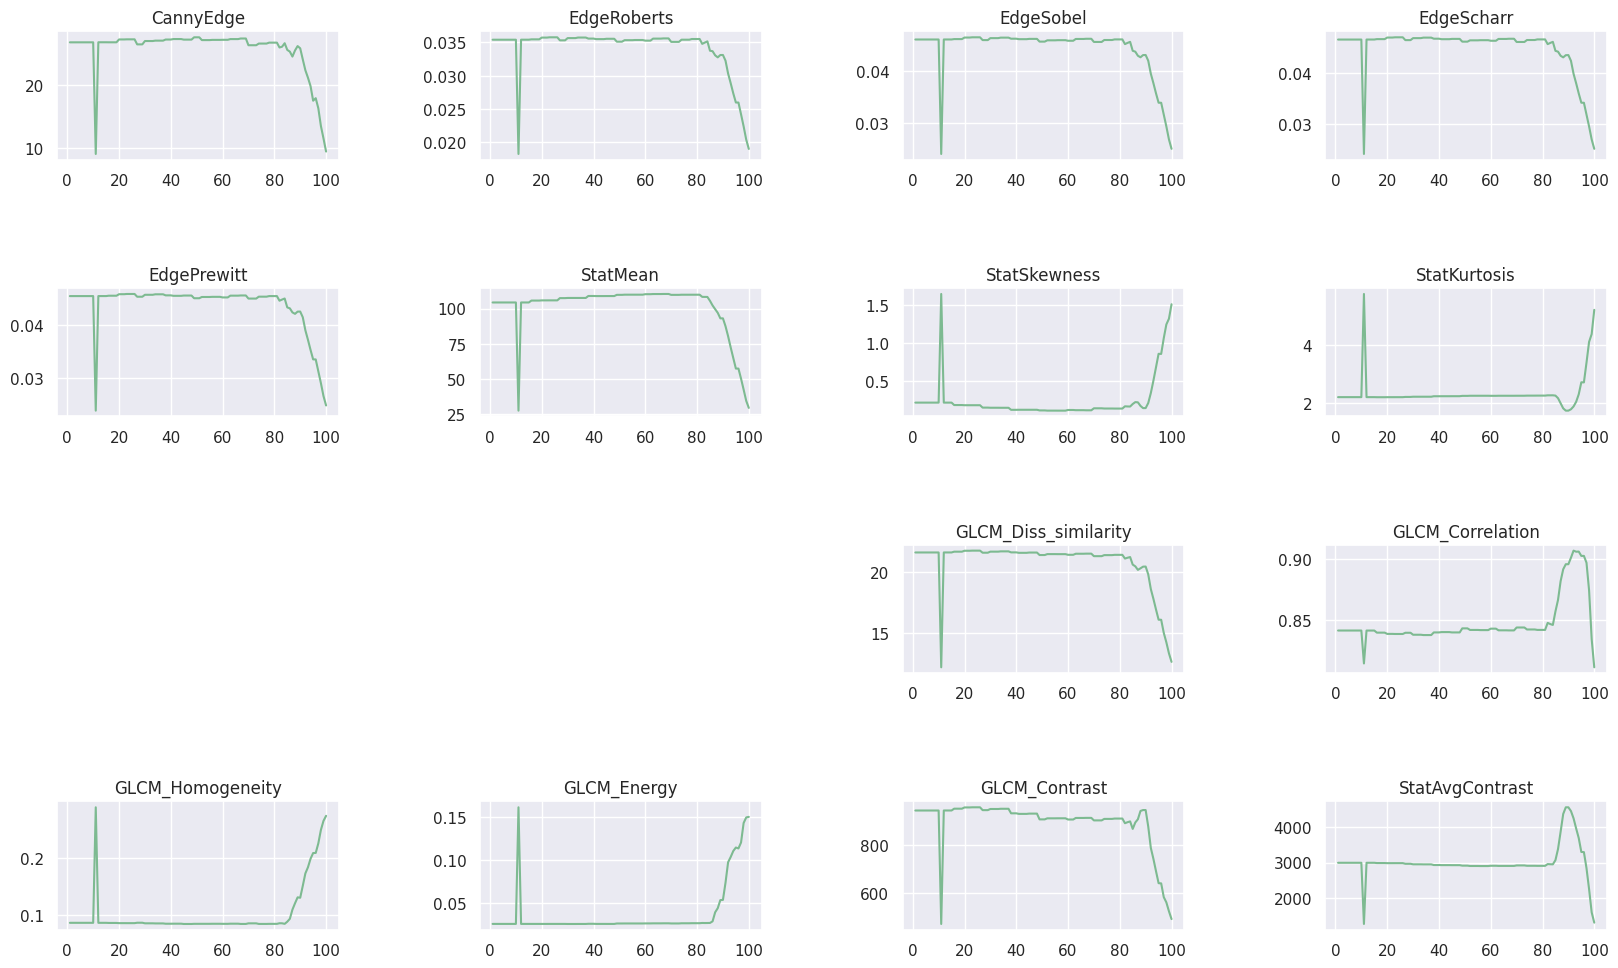

In [ ]:
fig = plt.figure( figsize=(20, 15))
fig.subplots_adjust(hspace=1, wspace=0.5)
fig.add_subplot(5,4,1).set_title('CannyEdge')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['CannyEdge'], label="CannyEdge")
fig.add_subplot(5,4,2).set_title('EdgeRoberts')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['EdgeRoberts'], label="EdgeRoberts")
fig.add_subplot(5,4,3).set_title('EdgeSobel')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['EdgeSobel'], label="EdgeSobel")
fig.add_subplot(5,4,4).set_title('EdgeScharr')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['EdgeScharr'], label="EdgeScharr")
fig.add_subplot(5,4,5).set_title('EdgePrewitt')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['EdgePrewitt'], label="EdgePrewitt")
fig.add_subplot(5,4,6).set_title('StatMean')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['StatMean'], label="StatMean")
fig.add_subplot(5,4,7).set_title('StatSkewness')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['StatSkewness'], label="StatSkewness")
fig.add_subplot(5,4,8).set_title('StatKurtosis')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['StatKurtosis'], label="StatKurtosis")
fig.add_subplot(5,4,11).set_title('GLCM_Diss_similarity')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['GLCM_Diss_similarity'], label="GLCM_Diss_similarity")
fig.add_subplot(5,4,12).set_title('GLCM_Correlation')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['GLCM_Correlation'], label="GLCM_Correlation")
fig.add_subplot(5,4,13).set_title('GLCM_Homogeneity')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['GLCM_Homogeneity'], label="GLCM_Homogeneity")
fig.add_subplot(5,4,14).set_title('GLCM_Energy')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['GLCM_Energy'], label="GLCM_Energy")
fig.add_subplot(5,4,15).set_title('GLCM_Contrast')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['GLCM_Contrast'], label="GLCM_Contrast")
fig.add_subplot(5,4,16).set_title('StatAvgContrast')
plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures['StatAvgContrast'], label="StatAvgContrast")

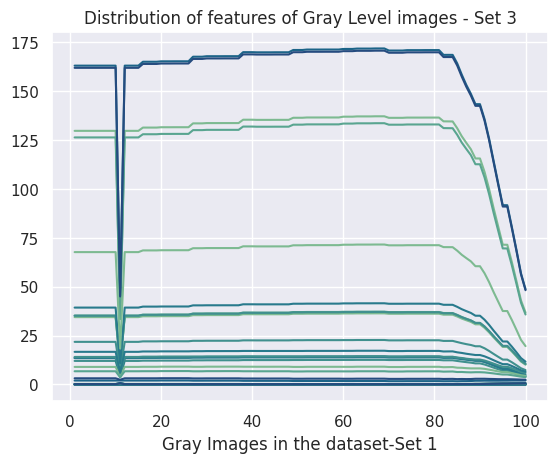

In [ ]:
Gabor_plot_label_i = 0
for i in range(31):
  Gabor_plot_label = 'GB' + str(i)
  plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures[Gabor_plot_label], label=Gabor_plot_label)
  Gabor_plot_label_i += 1

plt.xlabel('Gray Images in the dataset-Set 1')
plt.title('Distribution of features of Gray Level images - Set 3')
plt.show()

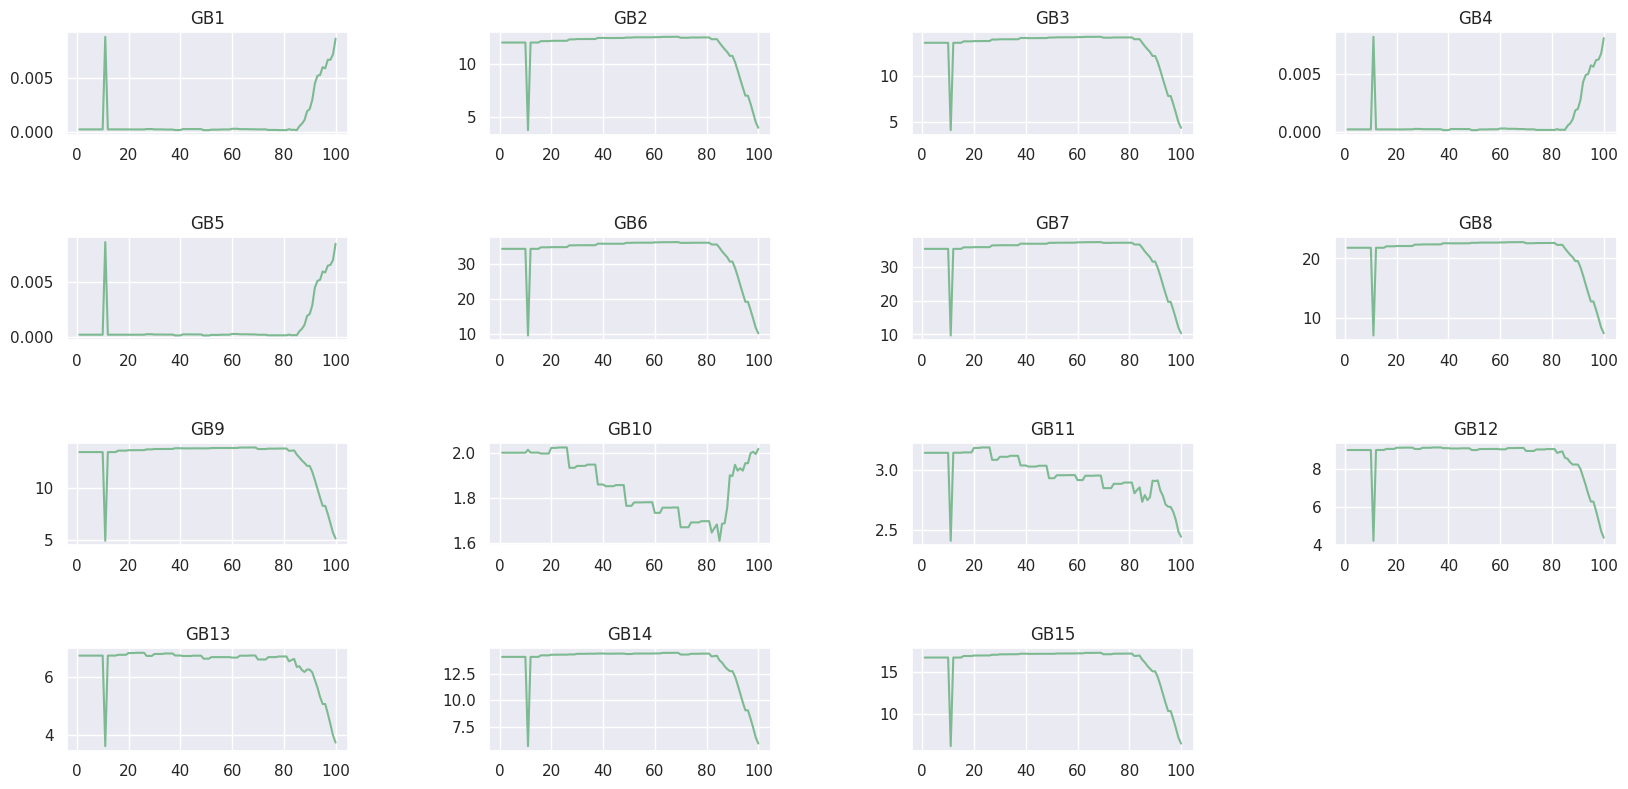

In [ ]:
fig = plt.figure( figsize=(20, 20))
fig.subplots_adjust(hspace=1, wspace=0.5)
Gabor_plot_label_i_new = 0
for i in range(15):
  i = i+1
  Gabor_plot_label = 'GB' + str(i)
  fig.add_subplot(8,4,i).set_title(Gabor_plot_label)
  plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures[Gabor_plot_label], label=Gabor_plot_label)
  Gabor_plot_label_i_new += 1

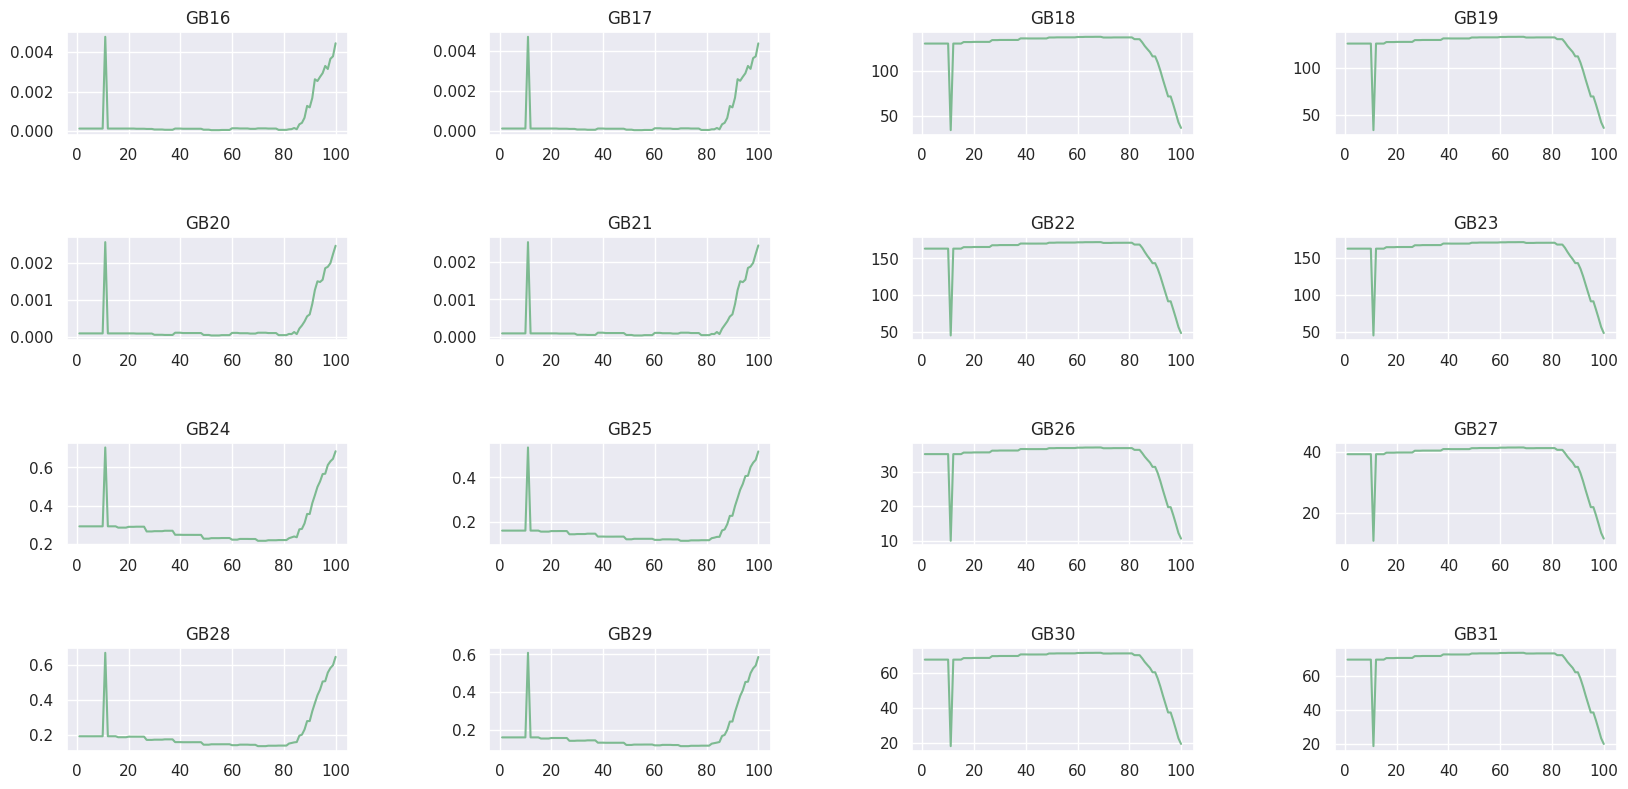

In [ ]:
fig = plt.figure( figsize=(20, 20))
fig.subplots_adjust(hspace=1, wspace=0.5)
Gabor_plot_label_i_new = 0
num = 1
for i in range(15,31):
  i = i+1
  Gabor_plot_label = 'GB' + str(i)
  fig.add_subplot(8,4,num).set_title(Gabor_plot_label)
  plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures[Gabor_plot_label], label=Gabor_plot_label)
  Gabor_plot_label_i_new += 1
  num += 1

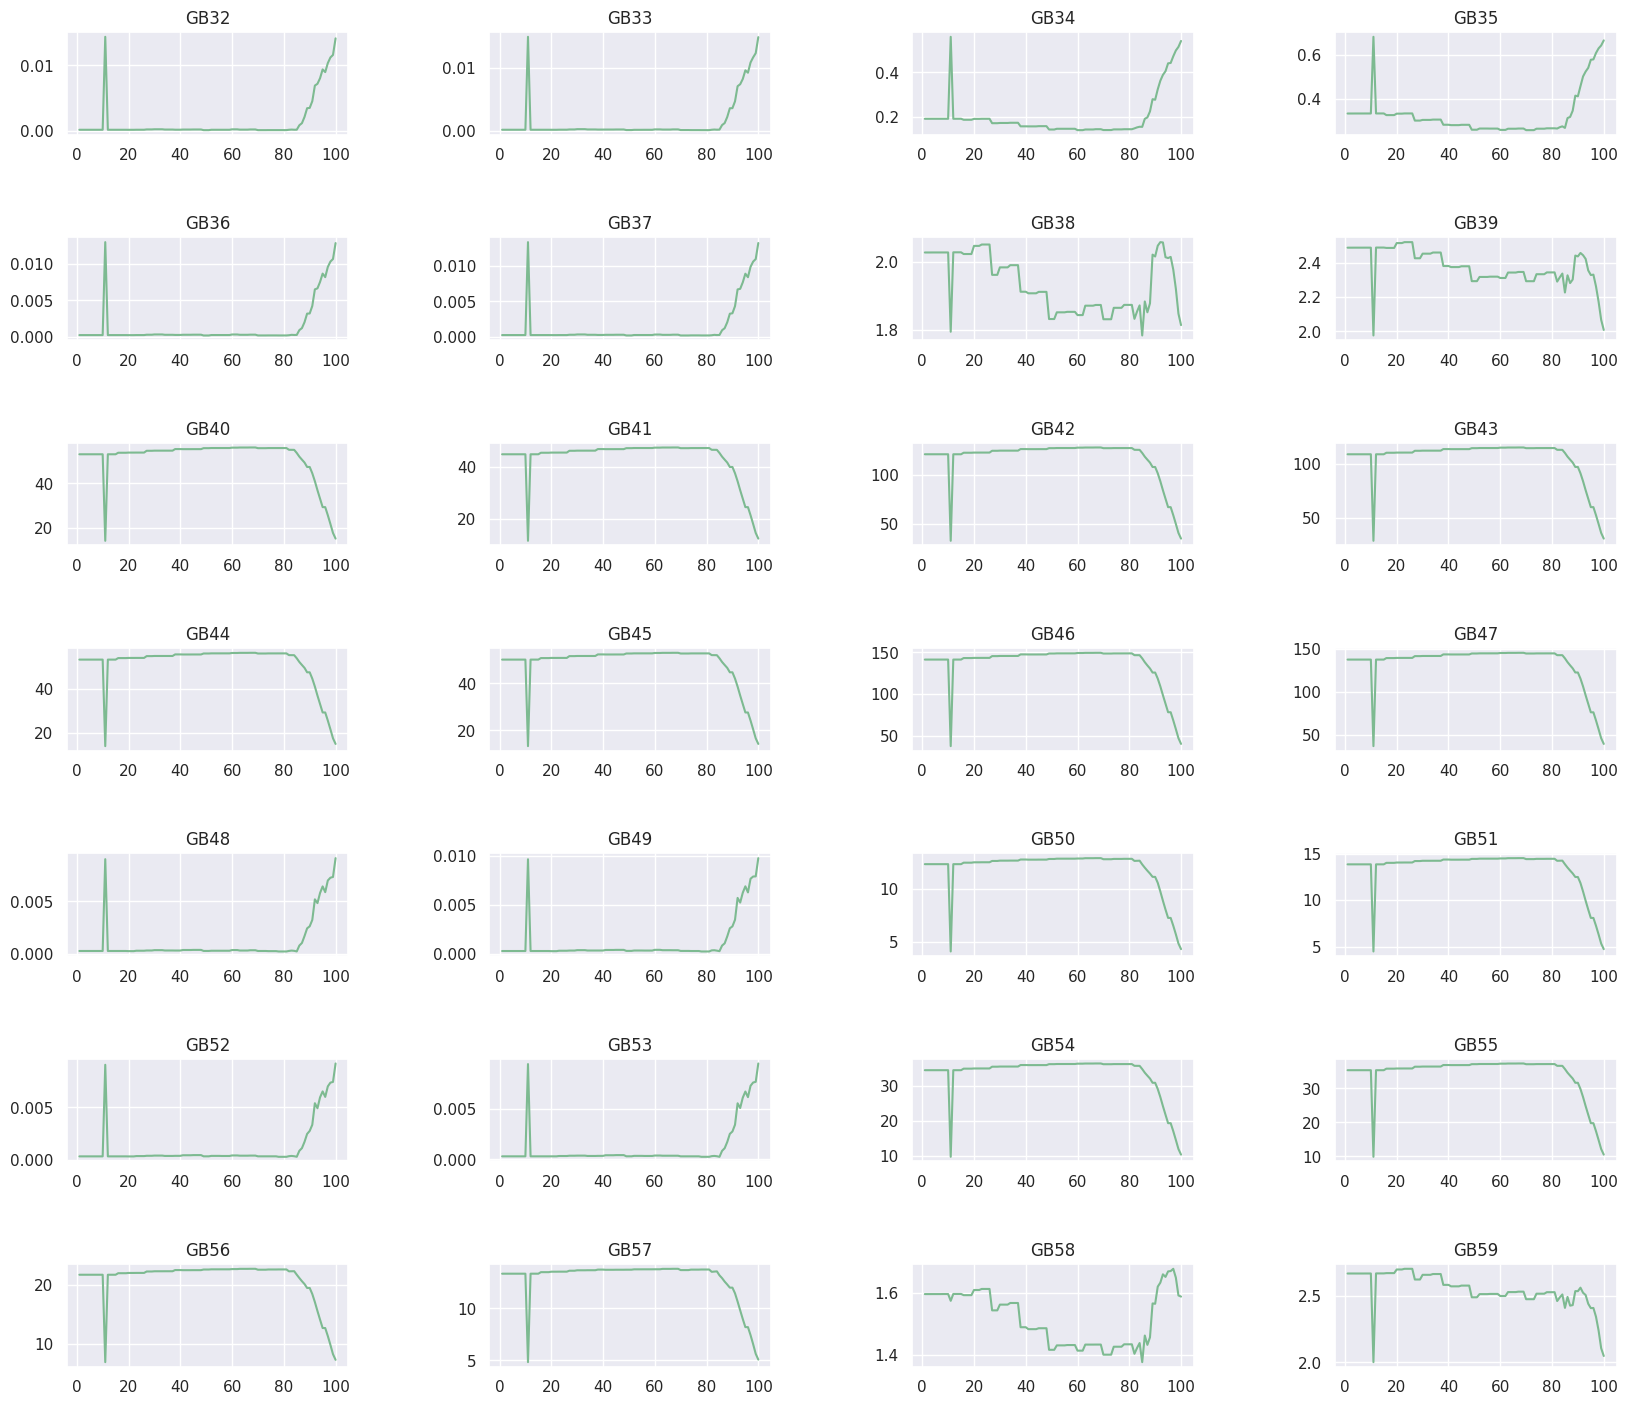

In [ ]:
fig = plt.figure( figsize=(20, 20))
fig.subplots_adjust(hspace=1, wspace=0.5)
Gabor_plot_label_i_new = 0
num = 1
for i in range(31,59):
  i = i+1
  Gabor_plot_label = 'GB' + str(i)
  fig.add_subplot(8,4,num).set_title(Gabor_plot_label)
  plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures[Gabor_plot_label], label=Gabor_plot_label)
  Gabor_plot_label_i_new += 1
  num += 1

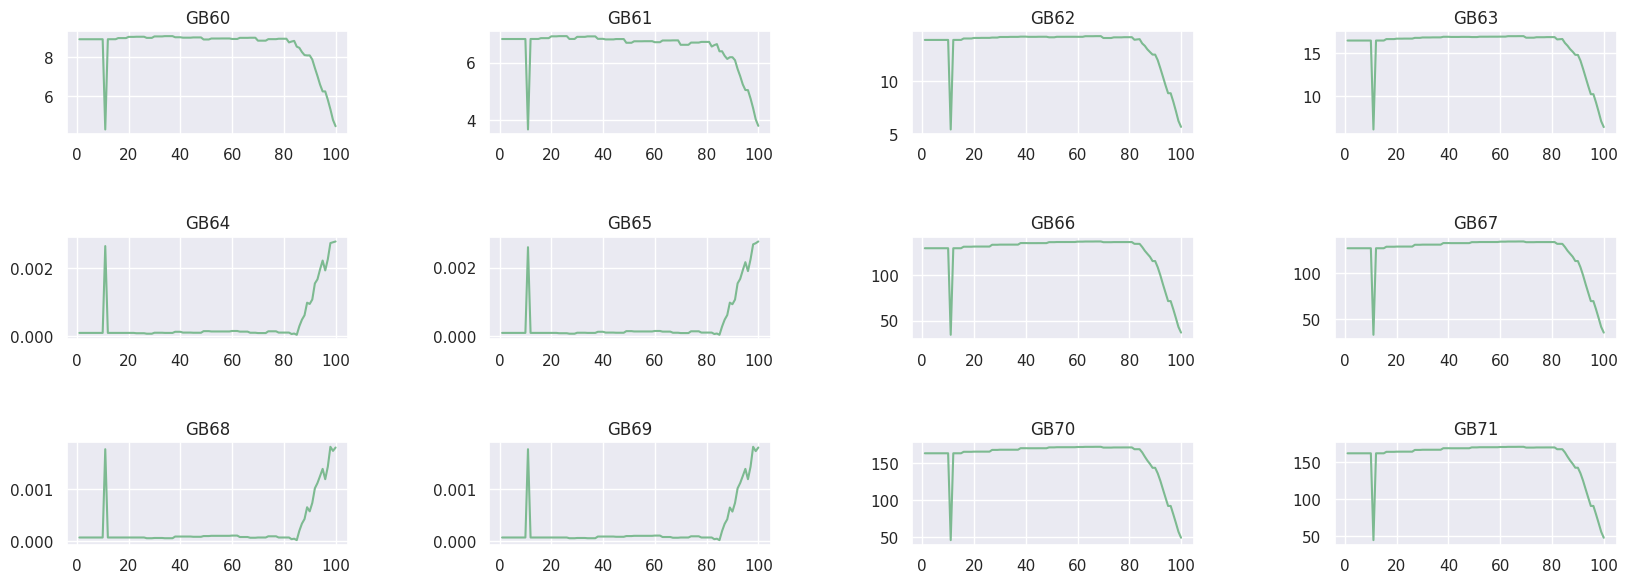

In [ ]:
fig = plt.figure( figsize=(20, 20))
fig.subplots_adjust(hspace=1, wspace=0.5)
Gabor_plot_label_i_new = 0
num = 1
for i in range(59,71):
  i = i+1
  Gabor_plot_label = 'GB' + str(i)
  fig.add_subplot(8,4,num).set_title(Gabor_plot_label)
  plt.plot(df_extractedFeatures['Gray Level Images'], df_extractedFeatures[Gabor_plot_label], label=Gabor_plot_label)
  Gabor_plot_label_i_new += 1
  num += 1

In [ ]:
colors = ["#2c3172"]
sn.set_palette(sn.color_palette(colors))

## Performing Principal Component Analysis for Dimensionlity Reduction.

In [ ]:
pca_start_time = time.time()

In [ ]:
def standardizeData(featureset):
  X_std = StandardScaler().fit_transform(featureset)
  print(X_std.shape)
  return X_std

In [ ]:
def getCovarianceMatrix(X_std):
   mean_vec= np.mean(X_std, axis=0)
   cov_mat = (X_std - mean_vec).T.dot((X_std-mean_vec)) / (X_std.shape[0]-1)
   print('Covariance matrix: \n%s' %cov_mat)
   return cov_mat

In [ ]:
def performPCA():
    featureset = df_extractedFeatures
    featureset.drop(['Gray Level Images'], axis = 1, inplace = True)

    X_std = standardizeData(featureset)

    pca = sklearnPCA(n_components=2)
    principalComponents_features = pca.fit_transform(X_std)
    print('PCA Variance ratio: ', pca.explained_variance_ratio_)
    principal_features = pd.DataFrame(data=principalComponents_features, columns=['principal component 1',
                                                                                  'principal component 2'])
    principal_features.to_csv('drive/MyDrive/UOM/FYP/Colab/D_SD_PCAFeatures.csv')

    return principal_features

In [ ]:
principal_features = performPCA()

(100, 86)
PCA Variance ratio:  [0.91418032 0.05452604]


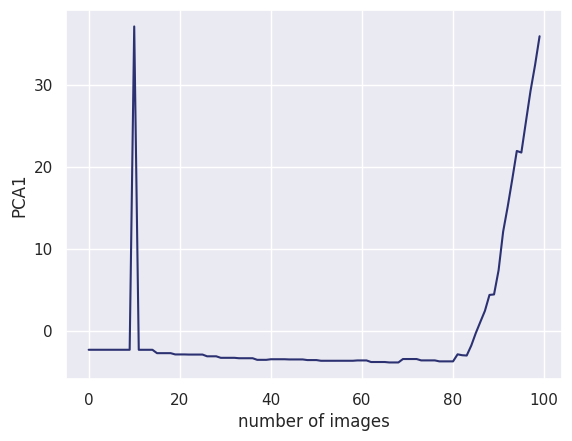

<Figure size 640x480 with 0 Axes>

In [ ]:
x = []
y = principal_features['principal component 1']
for i in range(len(dataset)):
  x.append(i)
plt.plot(x,y)
plt.xlabel('number of images')
plt.ylabel('PCA1')
plt.show()
plt.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/SmallDataset/PCA1.png')

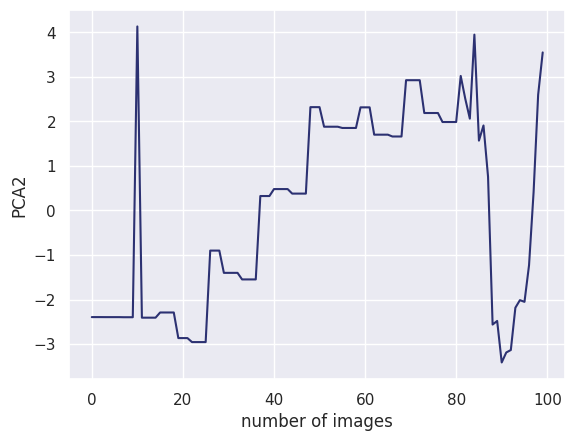

<Figure size 640x480 with 0 Axes>

In [ ]:
y_pca2 = principal_features['principal component 2']
plt.plot(x, y_pca2)
plt.xlabel('number of images')
plt.ylabel('PCA2')
plt.show()
plt.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/SmallDataset/PCA2.png')

In [ ]:
pca_end_time = time.time()

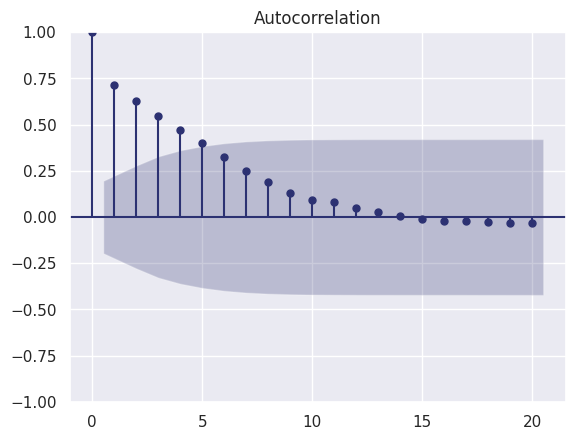

In [ ]:
acf_plot = plot_acf(principal_features['principal component 1']);

In [ ]:
acf_plot.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/SmallDataset/acf_of_data.png')

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


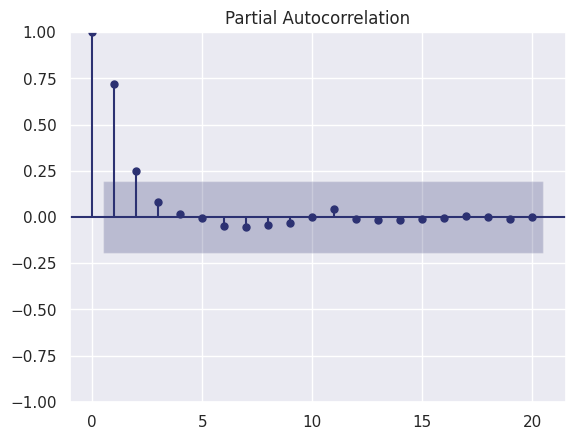

In [ ]:
pacf_plot = plot_pacf(principal_features['principal component 1']);

In [ ]:
pacf_plot.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/SmallDataset/pacf_plot_oF_data.png')

## ARIMA

### Reading and splitting the dataset

In [ ]:
file = pd.read_csv('/content/drive/MyDrive/UOM/FYP/Colab/D_SD_PCAFeatures.csv')
PCA1 = file["principal component 1"]

In [ ]:
def splitDataset(dataset, split_percentage):
  size = int(dataset_length * (split_percentage/100))
  train, test = dataset[0:size], dataset[size:dataset_length]
  print(train.head(5))
  print(test.head(5))
  return train, test, size

In [ ]:
train_set, test_set, split_image = splitDataset(PCA1, split_percentage)
train_set_length = len(train_set)
test_set_length = len(test_set)

0   -2.307911
1   -2.307911
2   -2.307911
3   -2.307855
4   -2.307855
Name: principal component 1, dtype: float64
70   -3.436495
71   -3.436495
72   -3.436495
73   -3.602220
74   -3.602220
Name: principal component 1, dtype: float64


### ARIMA model training

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
arima_start_time = time.time()

In [ ]:
def performARIMA(train_set):
  arima_result = auto_arima(train_set)
  print(arima_result)
  print("\n")
  print(arima_result.summary())

  result_string = str(arima_result)
  number_of_diffs = int(result_string[9])
  print("The number of differences needed to make the data stationary: ", number_of_diffs)

  return arima_result, number_of_diffs

In [ ]:
arima_result, number_of_diffs = performARIMA(train_set)

 ARIMA(0,0,0)(0,0,0)[0] intercept


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   70
Model:                        SARIMAX   Log Likelihood                -209.195
Date:                Fri, 09 Jun 2023   AIC                            422.389
Time:                        05:46:36   BIC                            426.886
Sample:                             0   HQIC                           424.176
                                 - 70                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.5917      5.182     -0.500      0.617     -12.748       7.565
sigma2        23.0834      6.156      3.750      0.000      11.018      35.149
Ljung-Box (L1) (

In [ ]:
arima_end_time = time.time()

### Plotting Residuals

In [ ]:
def getResiduals(arima_result, number_of_diffs):
  residuals = pd.DataFrame(arima_result.resid())
  filtered_residuals = residuals[(number_of_diffs):]
  return filtered_residuals

In [ ]:
residuals = getResiduals(arima_result, number_of_diffs)

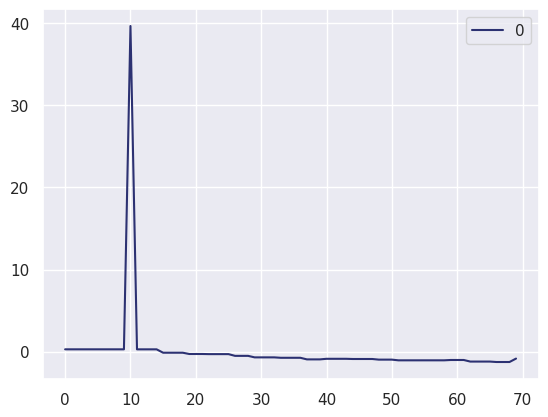

In [ ]:
plt_resids = residuals.plot()
plt_resids.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/SmallDataset/plt_residuals.png')

<ipython-input-75-72b09dcd4ece>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  density_plot = sn.distplot(residuals, kde=True)


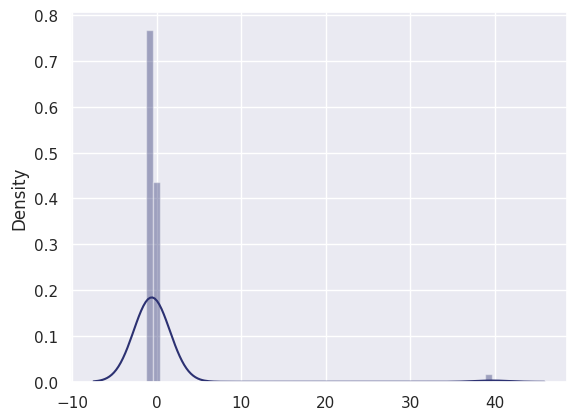

In [ ]:
density_plot = sn.distplot(residuals, kde=True)
density_plot.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/SmallDataset/density_plot.png')

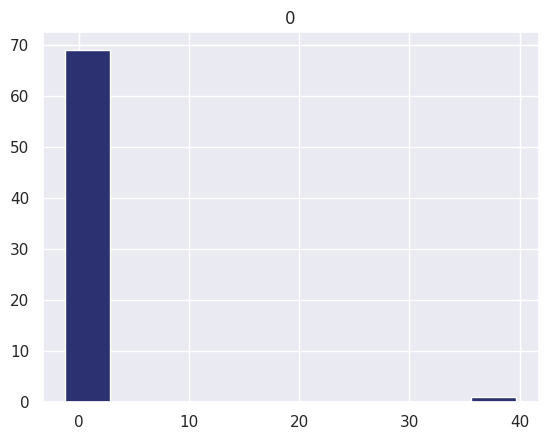

In [ ]:
residuals.hist()
plt.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/SmallDataset/residuals_histogram.png')

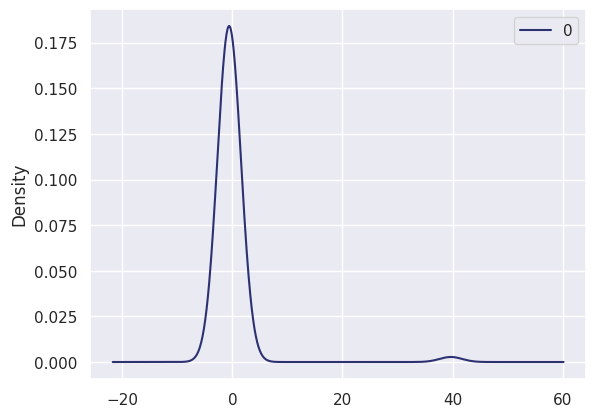

In [ ]:
residuals.plot(kind='kde')
plt.show()

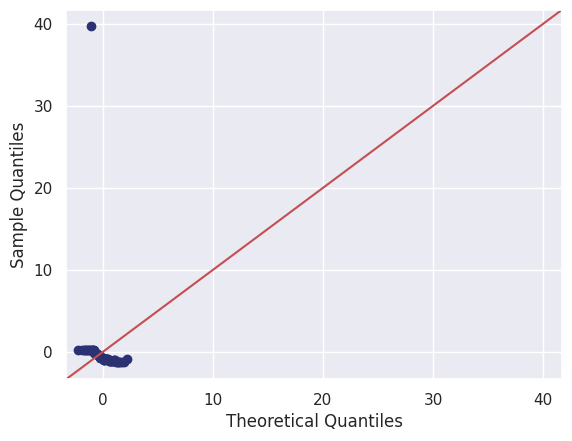

In [ ]:
residuals_qq = qqplot(residuals, line='45')
plt.show()

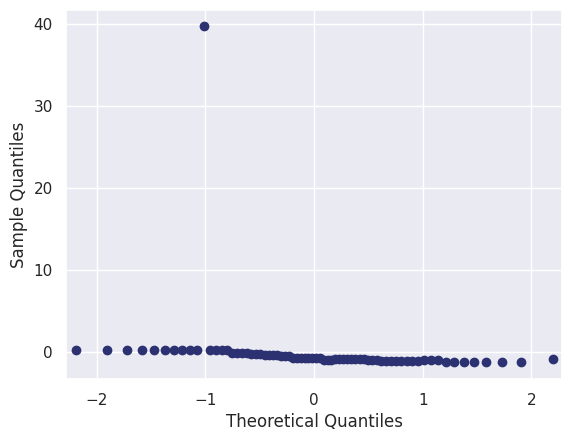

In [ ]:
qqplot(residuals)
plt.show()

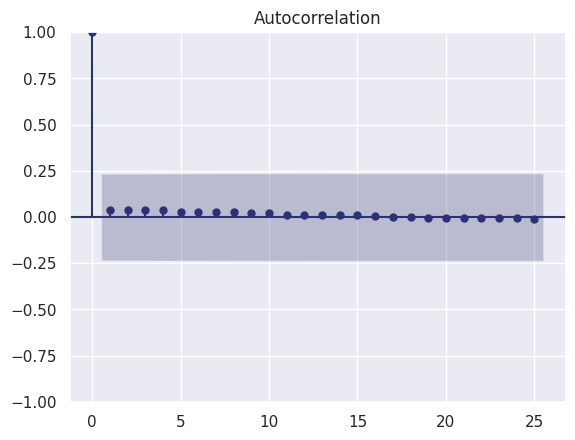

In [ ]:
residuals_acf = plot_acf(residuals, lags=25)
residuals_acf.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/SmallDataset/residuals_acf.png')

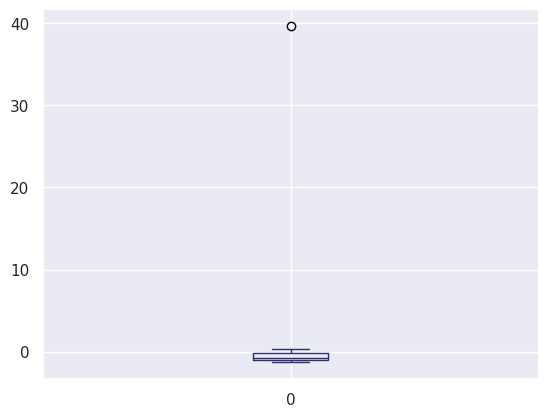

In [ ]:
residuals_boxPlot = residuals.plot.box(grid='True')
residuals_boxPlot.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/SmallDataset/residuals_boxPlot.png')

### Residual Description

In [ ]:
def calculateBoxPlotValues(residuals):
  residuals_description = residuals.describe()
  df_residuals_description = pd.DataFrame(residuals_description)
  min = float(df_residuals_description.loc["25%"]) - 1.5 * (float(df_residuals_description.loc["75%"])-float(df_residuals_description.loc["25%"])) #
  max = float(df_residuals_description.loc["75%"]) + 1.5 * (float(df_residuals_description.loc["75%"])-float(df_residuals_description.loc["25%"]))
  print("Minimum values is: ", min)
  print("Maximum values is: ",max)
  return max, min

In [ ]:
boxPlotMax, boxPlotMin = calculateBoxPlotValues(residuals)
anomalous_threshold = boxPlotMax

Minimum values is:  -2.31600064825588
Maximum values is:  1.1820243937404429


## Forecasting

In [ ]:
forecast_start_time = time.time()

In [ ]:
def performForecasting(arima_result, test_set_length, test):
  forecast = arima_result.predict(test_set_length, alpha=0.05)
  print(forecast)
  fc_series = pd.Series(forecast, index=test.index)
  return fc_series

In [ ]:
forecasted_series = performForecasting(arima_result, test_set_length, test_set)

70   -2.591728
71   -2.591728
72   -2.591728
73   -2.591728
74   -2.591728
75   -2.591728
76   -2.591728
77   -2.591728
78   -2.591728
79   -2.591728
80   -2.591728
81   -2.591728
82   -2.591728
83   -2.591728
84   -2.591728
85   -2.591728
86   -2.591728
87   -2.591728
88   -2.591728
89   -2.591728
90   -2.591728
91   -2.591728
92   -2.591728
93   -2.591728
94   -2.591728
95   -2.591728
96   -2.591728
97   -2.591728
98   -2.591728
99   -2.591728
dtype: float64


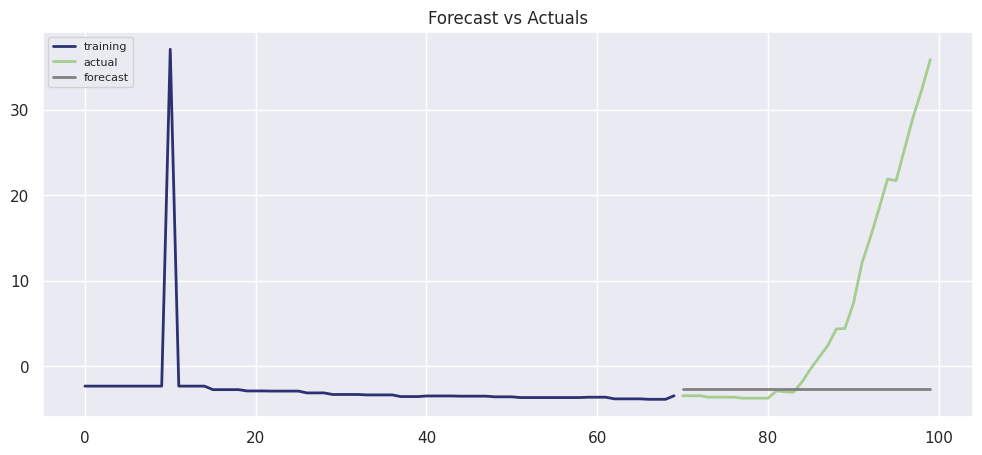

In [ ]:
forecastPlot = plt.figure(figsize=(12,5), dpi=100)
forecastPlot = plt.plot(train_set, label='training', color="#2c3172", linewidth=2)
forecastPlot = plt.plot(test_set, label='actual', color="#a5cd90", linewidth=2)
forecastPlot = plt.plot(forecasted_series, label='forecast', color='grey', linewidth=2)
forecastPlot = plt.title('Forecast vs Actuals')
forecastPlot = plt.legend(loc='upper left', fontsize=8)
# plt.show()
forecastPlot.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/SmallDataset/forecastVSActualsPlotWithoutThreshold.png')

In [ ]:
forecast_end_time = time.time()

## Binary Classification

In [ ]:
classification_start_time = time.time()

Calculating the forecast errors using the forecasted series and the actual values of the test series

In [ ]:
def calculateForecastErrors(fc_series, test, train_set_length):
  y_hat_values = []
  i = train_set_length
  print(i)
  for value in fc_series:
    y_hat = test[i] - value
    y_hat_values.append(y_hat)
    i = i + 1

  df_Forecasted_Series = pd.DataFrame(np.array(y_hat_values).astype(np.float), index = range(split_image, dataset_length), columns = ['Forecasted_Error'])
  return df_Forecasted_Series

In [ ]:
df_Forecasted_Series = calculateForecastErrors(forecasted_series, test_set, train_set_length)

70


<ipython-input-90-d059dc617e2a>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_Forecasted_Series = pd.DataFrame(np.array(y_hat_values).astype(np.float), index = range(split_image, dataset_length), columns = ['Forecasted_Error'])


In [ ]:
def classification(df_Forecasted_Series, anomalous_threshold, anomaly_image):
  index = df_Forecasted_Series.index
  for i in index:
    error = df_Forecasted_Series["Forecasted_Error"].loc[i]
    #Classify residuals as normal/anomaly
    if (error>anomalous_threshold):
      df_Forecasted_Series.loc[i, 'Predicted_Class'] = "Anomaly"
    else:
      df_Forecasted_Series.loc[i, 'Predicted_Class'] = "Normal"

    #Set the actual class
    if(i>=anomaly_image):
      df_Forecasted_Series.loc[i, 'Actual_Class'] = "Anomaly"
    else:
      df_Forecasted_Series.loc[i, 'Actual_Class'] = "Normal"

  return df_Forecasted_Series

In [ ]:
df_Forecasted_Series = classification(df_Forecasted_Series, anomalous_threshold, anomaly_image)

In [ ]:
df_Forecasted_Series

,Forecasted_Error,Predicted_Class,Actual_Class
70,-0.844767,Normal,Normal
71,-0.844767,Normal,Normal
72,-0.844767,Normal,Normal
73,-1.010492,Normal,Normal
74,-1.010492,Normal,Normal
75,-1.010492,Normal,Normal
76,-1.010492,Normal,Normal
77,-1.129492,Normal,Normal
78,-1.129492,Normal,Normal
79,-1.129492,Normal,Normal


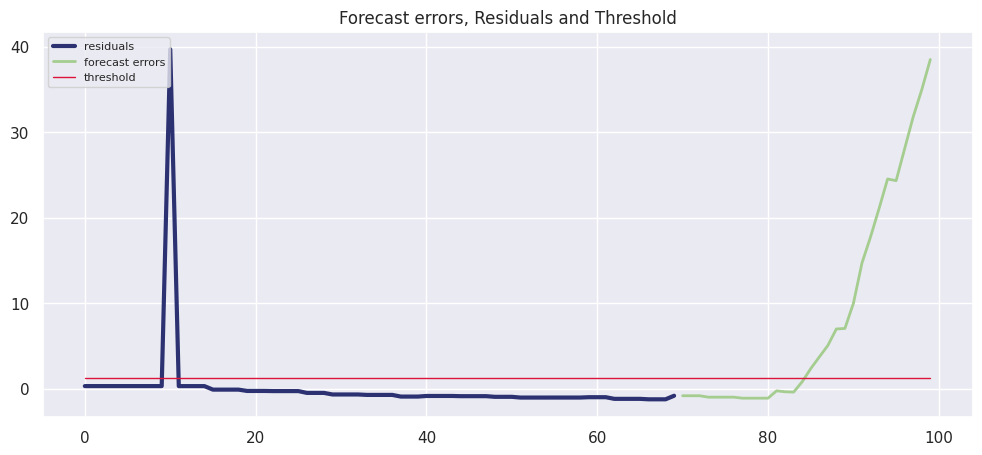

In [ ]:
max_threshold_series = np.full((dataset_length,1), anomalous_threshold)
forecast_error_series = df_Forecasted_Series["Forecasted_Error"]
thresholdPlot = plt.figure(figsize=(12,5), dpi=100)
thresholdPlot = plt.plot(residuals, label='residuals', color="#2c3172", linewidth=3)
thresholdPlot = plt.plot(forecast_error_series, label='forecast errors', color="#a5cd90", linewidth=2)
thresholdPlot = plt.plot(max_threshold_series, label='threshold', color='crimson', linewidth=1)
thresholdPlot = plt.title('Forecast errors, Residuals and Threshold')
thresholdPlot = plt.legend(loc='upper left', fontsize=8)
# plt.show()
thresholdPlot.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/SmallDataset/BoxPlot_Forecast_Actuals_plotWithThreshold.png')

In [ ]:
classification_end_time = time.time()

In [ ]:
end_time = time.time()

## Measuring Performance

In [ ]:
def getConfusionPLot(df_Forecasted_Series):
  confusionMatrix = confusion_matrix(df_Forecasted_Series['Actual_Class'], df_Forecasted_Series['Predicted_Class'])
  print(confusionMatrix)

  sn.heatmap(confusionMatrix, annot=True, fmt='.2f', cmap='crest')

  return confusionMatrix

[[15  5]
 [ 0 10]]


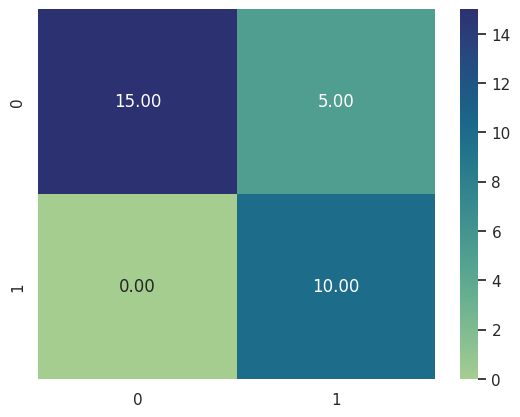

In [ ]:
confusionMatrix = getConfusionPLot(df_Forecasted_Series)
plt.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/SmallDataset/confusionMatrix.png')

It is important to note that,


> our objective function = finding an anomaly

So, the positive class should favour it.


> Positive class = anomaly behaviour (0)


> Negative class = normal behaviour (1)








> ▶True positives => True label:Anomaly, Predicted label:Anomaly [0,0]


> ▶True negatives => True label:Normal, Predicted label:Normal [1,1]


> ▶False positives => True label:Normal, Predicted label:Anomaly [1,0]


> ▶False negatives => True label:Anomaly, Predicted label:Normal [0,1]

Original example for ravel() was,


> TN,FP,FN,TP = confusionmatrix.ravel()



In [ ]:
def checkPerformance(confusionMatrix, test_set_length, dataset_length, anomaly_image, split_image):
  True_positives,False_negatives,False_positives,True_negatives = confusionMatrix.ravel()
  print("True positives: ", True_positives)
  print("True negatives: ", True_negatives)
  print("False positives: ", False_positives)
  print("False negatives: ", False_negatives)

  accuracy = (True_positives+True_negatives)/(True_positives+True_negatives+False_positives+False_negatives)
  print("accuracy: ", accuracy)
  sensitivity = True_positives/(True_positives+False_negatives) #Sn
  print("sensitivity: ", sensitivity)
  specificity = True_negatives/(True_negatives+False_positives) #Sp
  print("specificity: ", specificity)
  positive_predictive_value = True_positives/(True_positives+False_positives)
  print("positive_predictive_value: ", positive_predictive_value)
  negative_predictive_value = True_negatives/(True_negatives+False_negatives)
  print("negative_predictive_value: ", negative_predictive_value)
  precision = (True_positives+True_negatives)/(True_positives+True_negatives+False_positives+False_negatives)
  print("precision: ", precision)

  cc_numerator = True_positives*True_negatives - False_positives*False_negatives
  cc_denominator = math.sqrt(anomaly_image*(True_positives+False_positives)*abs((dataset_length-split_image)-anomaly_image)*(True_negatives+False_negatives))
  corr_coefficient = cc_numerator/cc_denominator
  print("corr_coefficient: ", corr_coefficient)

  anomalous_set_length = dataset_length - anomaly_image
  relationship_index = abs(specificity-sensitivity)/(specificity+sensitivity)
  P = specificity*(anomalous_set_length/test_set_length) + sensitivity*((test_set_length - anomalous_set_length)/test_set_length)
  OP = P-relationship_index
  print("OP:", OP)

  new_metric = math.sqrt((True_positives / (True_positives + False_negatives) )* (True_negatives /(True_negatives + False_positives)))
  print("G-Mean: ", new_metric)

  f1_score = 2 * ((positive_predictive_value * sensitivity) / (positive_predictive_value + sensitivity))
  print("F1 Score: ", f1_score)

In [ ]:
sensitivity = 50/(50+0) #Sn
specificity = 50/(50+0) #Sp

anomalous_set_length = 50
trelationship_index = abs(specificity-sensitivity)/(specificity+sensitivity)
tP = specificity*(anomalous_set_length/50) + sensitivity*((50 - anomalous_set_length)/50)
tOP = tP-trelationship_index
print(tOP)

1.0


In [ ]:
checkPerformance(confusionMatrix, test_set_length, dataset_length, anomaly_image, split_image)

True positives:  15
True negatives:  10
False positives:  0
False negatives:  5
accuracy:  0.8333333333333334
sensitivity:  0.75
specificity:  1.0
positive_predictive_value:  1.0
negative_predictive_value:  0.6666666666666666
precision:  0.8333333333333334
corr_coefficient:  0.15811388300841897
OP: 0.7738095238095237
G-Mean:  0.8660254037844386
F1 Score:  0.8571428571428571


## Time Taken

Total time taken for the small dataset **(in seconds)**

In [ ]:
total_time = end_time - start_time
total_time

446.8529005050659

Time taken for the pre-processing and feature extraction **(in seconds)**

In [ ]:
time_prep_and_extract = prep_and_extract_end_time - prep_and_extract_start_time
time_prep_and_extract

379.9920868873596

Time taken for the PCA **(in seconds)**

In [ ]:
time_PCA = pca_end_time - pca_start_time
time_PCA

1.9292268753051758

Time taken for ARIMA **(in seconds)**

In [ ]:
time_arima = arima_end_time - arima_start_time
time_arima

1.2038943767547607

Time taken for forecasting **(in seconds)**

In [ ]:
time_forecast = forecast_end_time - forecast_start_time
time_forecast

0.8050458431243896

Time taken for the binary classification **(in seconds)**

In [ ]:
time_classification = classification_end_time - classification_start_time
time_classification

0.9220080375671387

## Classification with EVT

### Import necessary libraries

In [ ]:
!pip install fitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fitter: filename=fitter-1.5.2-py3-none-any.whl size=25608 sha256=9ae14093be7e6656753ead91ea19e20f43ed3851bdaecfbeda32244003ab9088
  Stored in directory: /root/.cache/pip/wheels/eb/50/1d/6d8762c6a9a50d3668e53f98164ba13ca314827fb5ac7ebeaa
Successfully built fitter


In [ ]:
from fitter import Fitter
from scipy.stats import gumbel_l
from scipy.stats import gumbel_r

In [ ]:
evt_start_time = time.time()

### Threshold calculation using EVT

In [ ]:
from numpy.ma.core import absolute
def anomaly_threshold_evt(residuals, confidence):


  #Transforming the residuals
  extrem_prob_residuals = np.exp(-np.exp(-residuals))

  #fitting to the curve
  f1 = Fitter(extrem_prob_residuals, distributions=['gumbel_l'], bins=45)
  f1.fit()
  params = f1.get_best()
  confidence =1-confidence
  t = gumbel_l.ppf(confidence, loc=params.get("gumbel_l").get("loc"), scale=params.get("gumbel_l").get("scale"))

  t = absolute(t)

  #retransform
  threshold_val = np.log(-np.log(t))

  #print(threshold_val)

  return threshold_val

In [ ]:
evt_threshold = anomaly_threshold_evt(np.array(residuals), 0.95)

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 67.43it/s]


In [ ]:
evt_threshold

-0.20972437423354331

In [ ]:
evt_forecastedError_df = df_Forecasted_Series
evt_forecastedError_df = classification(evt_forecastedError_df, evt_threshold, anomaly_image)
evt_forecastedError_df

,Forecasted_Error,Predicted_Class,Actual_Class
70,-0.844767,Normal,Normal
71,-0.844767,Normal,Normal
72,-0.844767,Normal,Normal
73,-1.010492,Normal,Normal
74,-1.010492,Normal,Normal
75,-1.010492,Normal,Normal
76,-1.010492,Normal,Normal
77,-1.129492,Normal,Normal
78,-1.129492,Normal,Normal
79,-1.129492,Normal,Normal


[[16  4]
 [ 0 10]]


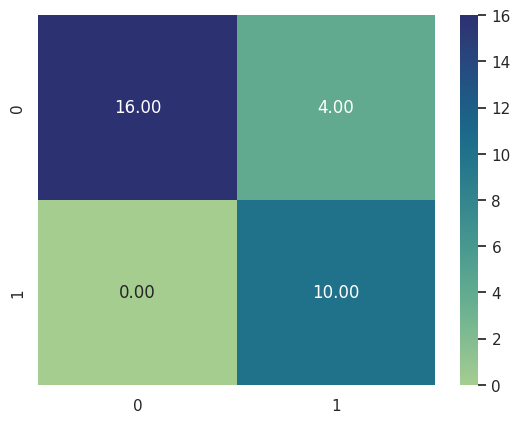

In [ ]:
evt_confusionMatrix = getConfusionPLot(df_Forecasted_Series)
plt.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/SmallDataset/evt_confusionMatrix.png')

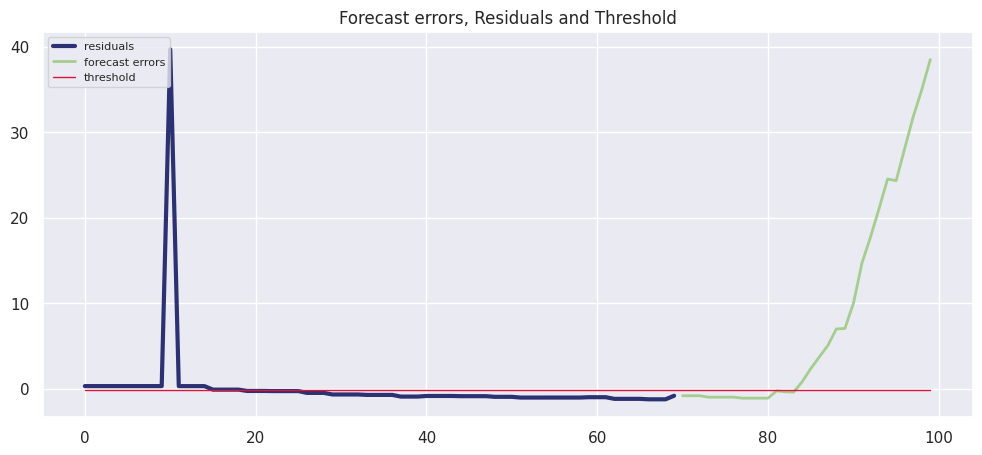

In [ ]:
evt_max_threshold_series = np.full((dataset_length,1), evt_threshold)
forecast_error_series = df_Forecasted_Series["Forecasted_Error"]
thresholdPlot = plt.figure(figsize=(12,5), dpi=100)
thresholdPlot = plt.plot(residuals, label='residuals', color= "#2c3172", linewidth=3)
thresholdPlot = plt.plot(forecast_error_series, label='forecast errors', color="#a5cd90", linewidth=2)
thresholdPlot = plt.plot(evt_max_threshold_series, label='threshold', color='crimson', linewidth=1)
thresholdPlot = plt.title('Forecast errors, Residuals and Threshold')
thresholdPlot = plt.legend(loc='upper left', fontsize=8)
# plt.show()
thresholdPlot.figure.savefig('drive/MyDrive/UOM/FYP/Colab/Images/Images_For_Journal/Deforestation/BigDataset/EVT_Forecast_Actuals_plotWithThreshold.png')

In [ ]:
checkPerformance(evt_confusionMatrix, test_set_length, dataset_length, anomaly_image, split_image)

True positives:  16
True negatives:  10
False positives:  0
False negatives:  4
accuracy:  0.8666666666666667
sensitivity:  0.8
specificity:  1.0
positive_predictive_value:  1.0
negative_predictive_value:  0.7142857142857143
precision:  0.8666666666666667
corr_coefficient:  0.16903085094570333
OP: 0.8222222222222223
G-Mean:  0.8944271909999159
F1 Score:  0.888888888888889
